In [20]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [21]:
import addict
import copy
import sys
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import matplotlib
import colorcet as cc
from importlib import reload
from tqdm.notebook import tqdm
from typing import List, Dict, Tuple

import celeri

plt.rcParams["text.usetex"] = False # Plotting the global model is much much faster with tex fonts turned off

# Read in data files, create storage dictionaries, and do basic processing

In [22]:
# Japan example
command_file_name = "../data/command/japan_command_new.json"

# Western North America example
# command_file_name = "../data/command/western_north_america_command.json"

In [23]:
command = celeri.get_command(command_file_name)
celeri.create_output_folder(command)
logger = celeri.get_logger(command)
segment, block, meshes, station, mogi, sar = celeri.read_data(command)
station = celeri.process_station(station, command)
segment = celeri.process_segment(segment, command, meshes)
sar = celeri.process_sar(sar, command)
closure, block = celeri.assign_block_labels(segment, station, block, mogi, sar)
assembly = addict.Dict()
operators = addict.Dict()
operators.meshes = [addict.Dict()] * len(meshes)
assembly = celeri.merge_geodetic_data(assembly, station, sar) # Not sure this works correctly

2023-03-02 21:33:21.974 | INFO     | celeri.celeri:get_logger:122 - Read: ../data/command/japan_command_new.json
2023-03-02 21:33:21.974 | INFO     | celeri.celeri:get_logger:123 - RUN_NAME: 2023-03-02-21-33-21
2023-03-02 21:33:21.975 | INFO     | celeri.celeri:get_logger:124 - Write log file: ../runs/2023-03-02-21-33-21/2023-03-02-21-33-21.log
2023-03-02 21:33:21.975 | INFO     | celeri.celeri:read_data:129 - Reading data files
2023-03-02 21:33:21.981 | SUCCESS  | celeri.celeri:read_data:133 - Read: ../data/segment/japan_segment_new.csv
2023-03-02 21:33:21.983 | SUCCESS  | celeri.celeri:read_data:138 - Read: ../data/block/japan_block.csv
2023-03-02 21:33:21.984 | SUCCESS  | celeri.celeri:read_data:145 - Read: ../data/mesh/japan_mesh_parameters.json



Warning: The file contains tag data that couldn't be processed.

2023-03-02 21:33:22.006 | SUCCESS  | celeri.celeri:read_data:265 - Read: ../data/mesh/nankai.msh



Warning: The file contains tag data that couldn't be processed.

2023-03-02 21:33:22.039 | SUCCESS  | celeri.celeri:read_data:265 - Read: ../data/mesh/japan.msh



Warning: The file contains tag data that couldn't be processed.

2023-03-02 21:33:22.067 | SUCCESS  | celeri.celeri:read_data:265 - Read: ../data/mesh/sagami.msh
2023-03-02 21:33:22.070 | SUCCESS  | celeri.celeri:read_data:301 - Read: ../data/station/japan_station.csv
2023-03-02 21:33:22.071 | INFO     | celeri.celeri:read_data:316 - No mogi_file_name
2023-03-02 21:33:22.072 | INFO     | celeri.celeri:read_data:338 - No sar_file_name


# Get elastic operators and TDE smoothing operators

In [24]:
# Get all elastic operators for segments and TDEs
celeri.get_elastic_operators(operators, meshes, segment, station, command)

# Get TDE smoothing operators
celeri.get_all_mesh_smoothing_matrices(meshes, operators)

2023-03-02 21:33:22.415 | INFO     | celeri.celeri:get_elastic_operators:1539 - Computing elastic operators


Calculating Okada partials for segments: 100%|██████████| 480/480 [00:04<00:00, 115.59it/s]

2023-03-02 21:33:26.573 | INFO     | celeri.celeri:get_elastic_operators:1547 - Start: TDE slip to velocity calculation for mesh: ../data/mesh/nankai.msh



Calculating cutde partials for triangles: 100%|██████████| 1902/1902 [00:12<00:00, 157.93it/s]

2023-03-02 21:33:38.629 | SUCCESS  | celeri.celeri:get_elastic_operators:1553 - Finish: TDE slip to velocity calculation for mesh: ../data/mesh/nankai.msh
2023-03-02 21:33:38.629 | INFO     | celeri.celeri:get_elastic_operators:1547 - Start: TDE slip to velocity calculation for mesh: ../data/mesh/japan.msh



Calculating cutde partials for triangles: 100%|██████████| 2621/2621 [00:21<00:00, 122.07it/s]

2023-03-02 21:34:00.118 | SUCCESS  | celeri.celeri:get_elastic_operators:1553 - Finish: TDE slip to velocity calculation for mesh: ../data/mesh/japan.msh
2023-03-02 21:34:00.118 | INFO     | celeri.celeri:get_elastic_operators:1547 - Start: TDE slip to velocity calculation for mesh: ../data/mesh/sagami.msh



Calculating cutde partials for triangles: 100%|██████████| 231/231 [00:01<00:00, 173.22it/s]

2023-03-02 21:34:01.453 | SUCCESS  | celeri.celeri:get_elastic_operators:1553 - Finish: TDE slip to velocity calculation for mesh: ../data/mesh/sagami.msh
2023-03-02 21:34:01.454 | INFO     | celeri.celeri:get_elastic_operators:1563 - Saving elastic to velocity matrices to :../data/operators/japan_elastic_operators.hdf5


# Calculate non-elastic operators

In [25]:
operators.rotation_to_velocities = celeri.get_rotation_to_velocities_partials(station, len(block))
operators.global_float_block_rotation = celeri.get_global_float_block_rotation_partials(station)
assembly, operators.block_motion_constraints = celeri.get_block_motion_constraints(assembly, block, command)
assembly, operators.slip_rate_constraints = celeri.get_slip_rate_constraints(assembly, segment, block, command)
operators.rotation_to_slip_rate = celeri.get_rotation_to_slip_rate_partials(segment, block)
operators.block_strain_rate_to_velocities, strain_rate_block_index = celeri.get_block_strain_rate_to_velocities_partials(block, station, segment)
operators.mogi_to_velocities = celeri.get_mogi_to_velocities_partials(mogi, station, command)
celeri.get_tde_slip_rate_constraints(meshes, operators)

2023-03-02 21:34:02.166 | INFO     | celeri.celeri:get_slip_rate_constraints:1196 - No slip rate constraints


# Plot input data

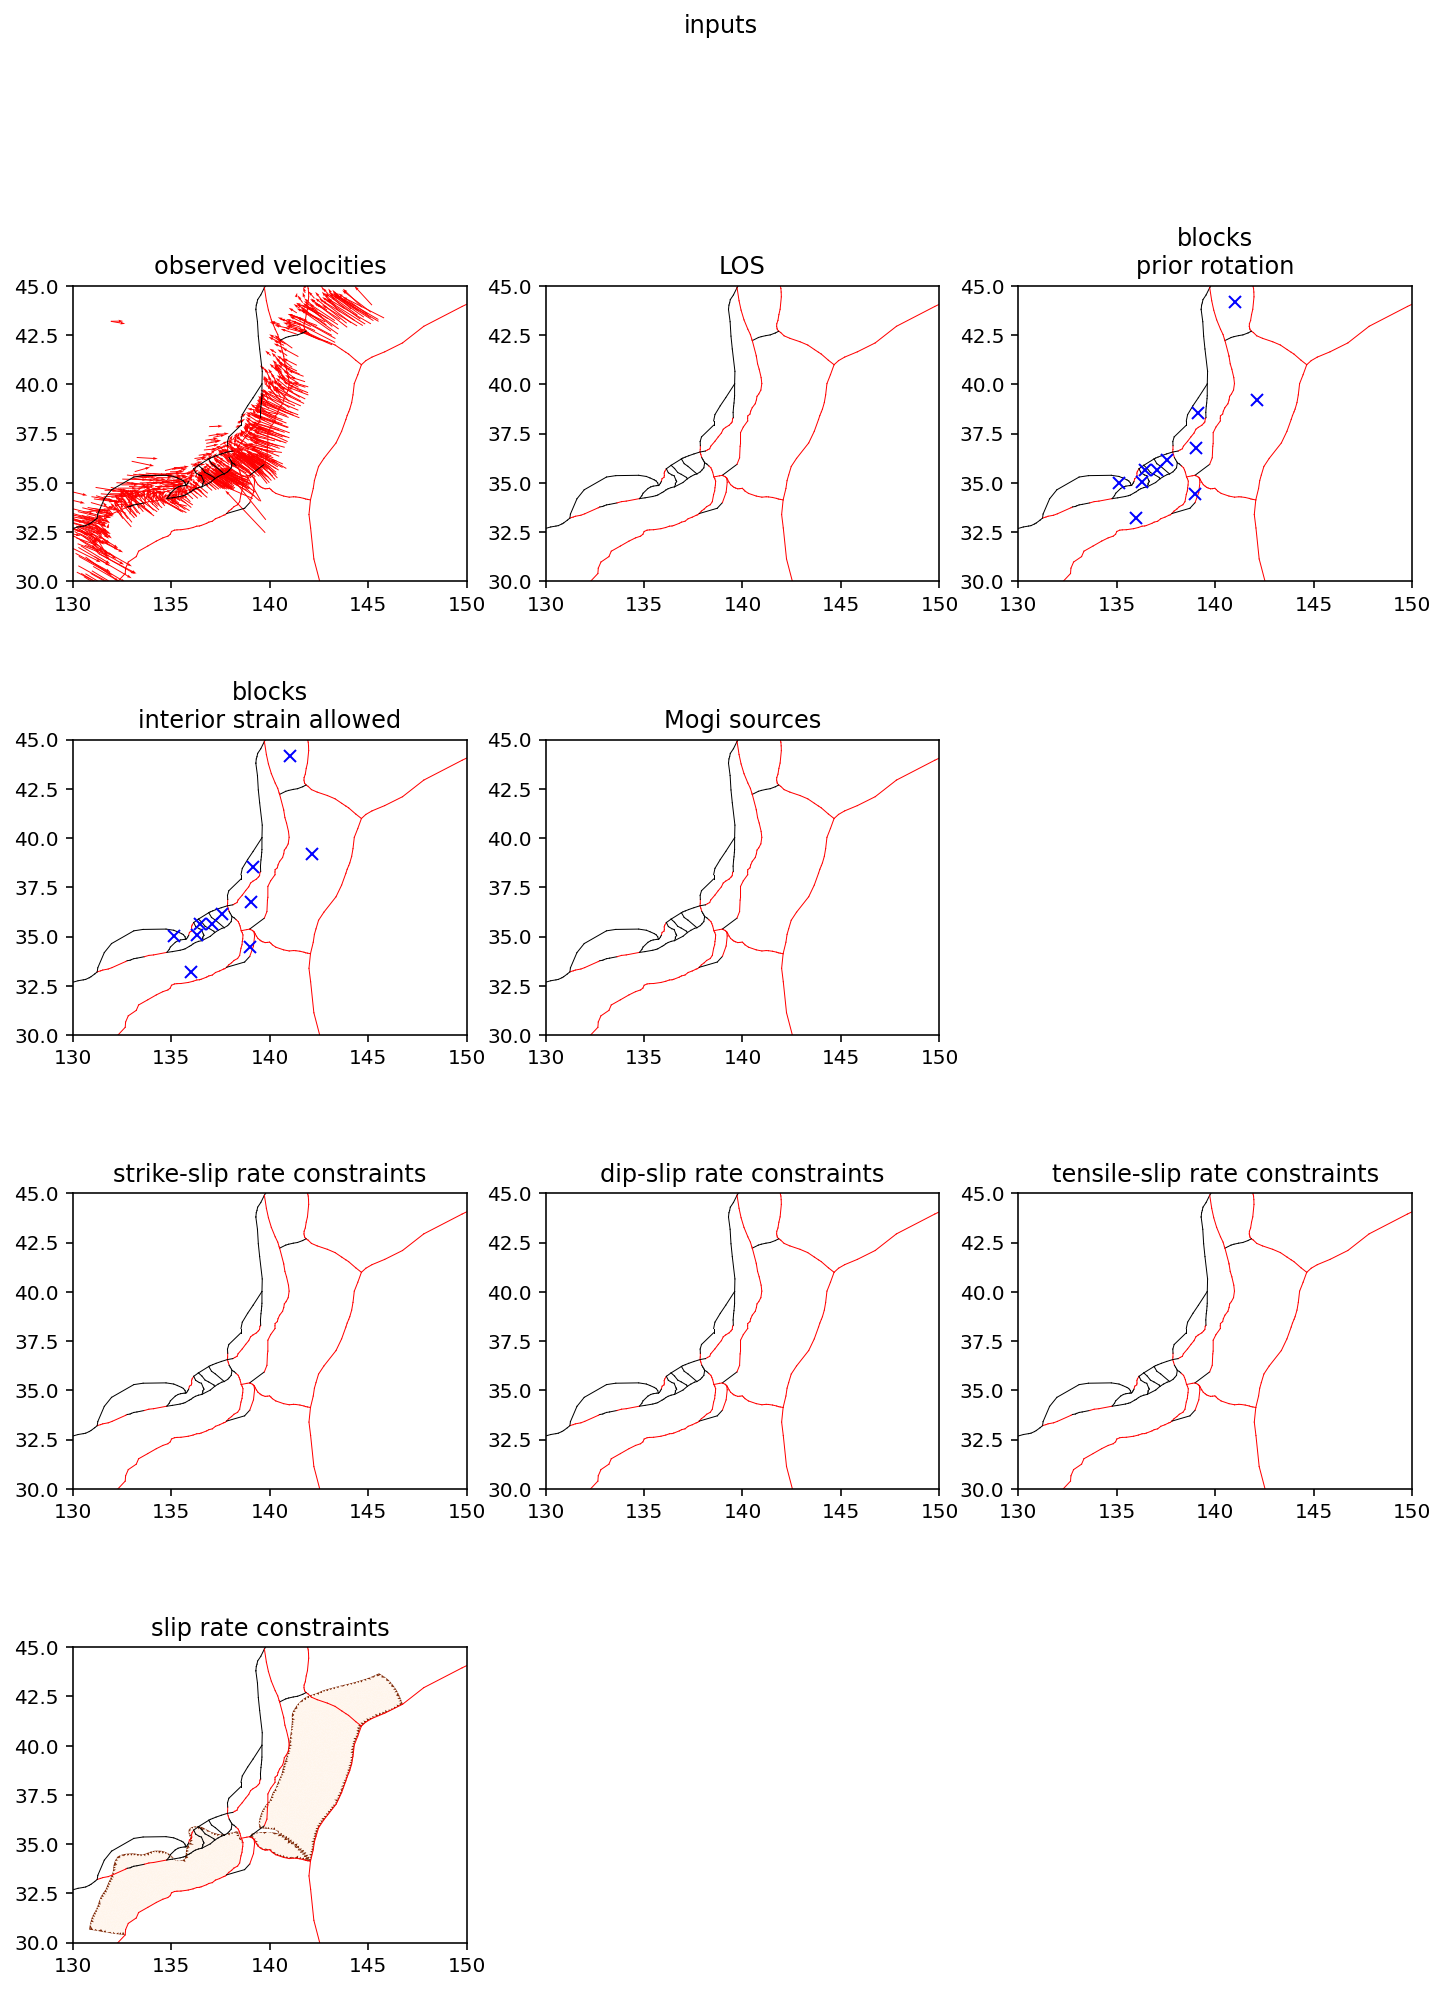

2023-03-02 21:34:04.708 | SUCCESS  | celeri.celeri:plot_input_summary:4044 - Wrote figures../runs/2023-03-02-21-33-21/plot_input_summary.(pdf, png)


<Figure size 432x288 with 0 Axes>

In [26]:
celeri.plot_input_summary(
    command,
    segment,
    station,
    block,
    meshes,
    mogi,
    sar,
    lon_range=command.lon_range,
    lat_range=command.lat_range,
    quiver_scale=1e2,
)


# Sketching out the assembly of the block model system

$$
\begin{bmatrix}
    \mathrm{geodetic \; velocities} \\
    \mathrm{plate \; rotation \; constraints} \\
    \mathrm{slip \; rate \; constraints} \\
    \mathrm{TDE \; smoothing \; pseudodata = 0} \\
    \mathrm{TDE \; rate \; constraints} \\
    \mathrm{InSAR \; LOS \; changes} 
\end{bmatrix}
=
\begin{bmatrix}
    \mathrm{(rotations-elastic \; segments) \; to \; velocities} & \mathrm{TDEs \; to \; velocities} & \mathrm{block \; strain \; rate \; to \; velocities} & \mathrm{Mogi \; to \; velocities}\\
    \mathrm{identities}                                          & 0                                   & 0 \\
    \mathrm{plate \; rotations \; to \; slip \; rates}           & 0                                   & 0 \\
    0                                                            & \mathrm{TDE \; smoothing \; matrix} & 0 \\
    0                                                            & \mathrm{identities}                 & 0 \\
    \mathrm{(rotations-elastic \; segments) \; to \; LOS}        & \mathrm{TDEs \; to \; LOS}          & \mathrm{block \; strain \; rate \; to \; velocities}
\end{bmatrix}
\begin{bmatrix}
    \mathrm{plate \; rotation \; rates} \\
    \mathrm{TDE \; slip \; rates} \\
    \mathrm{block \; strain \; rates} \\
    \mathrm{Mogi \; rates}
\end{bmatrix}
$$

# Estimate block model parameters (dense)

In [27]:
index, estimation = celeri.assemble_and_solve_dense(command, assembly, operators, station, block, meshes)
celeri.post_process_estimation(estimation, operators, station, index)
celeri.write_output(command, estimation, station, segment, block, meshes)

/Users/meade/Desktop/celeri/celeri/celeri.py:2776: RuntimeWarning: invalid value encountered in sqrt
  estimation.slip_rate_sigma = np.sqrt(


# Plot model summary

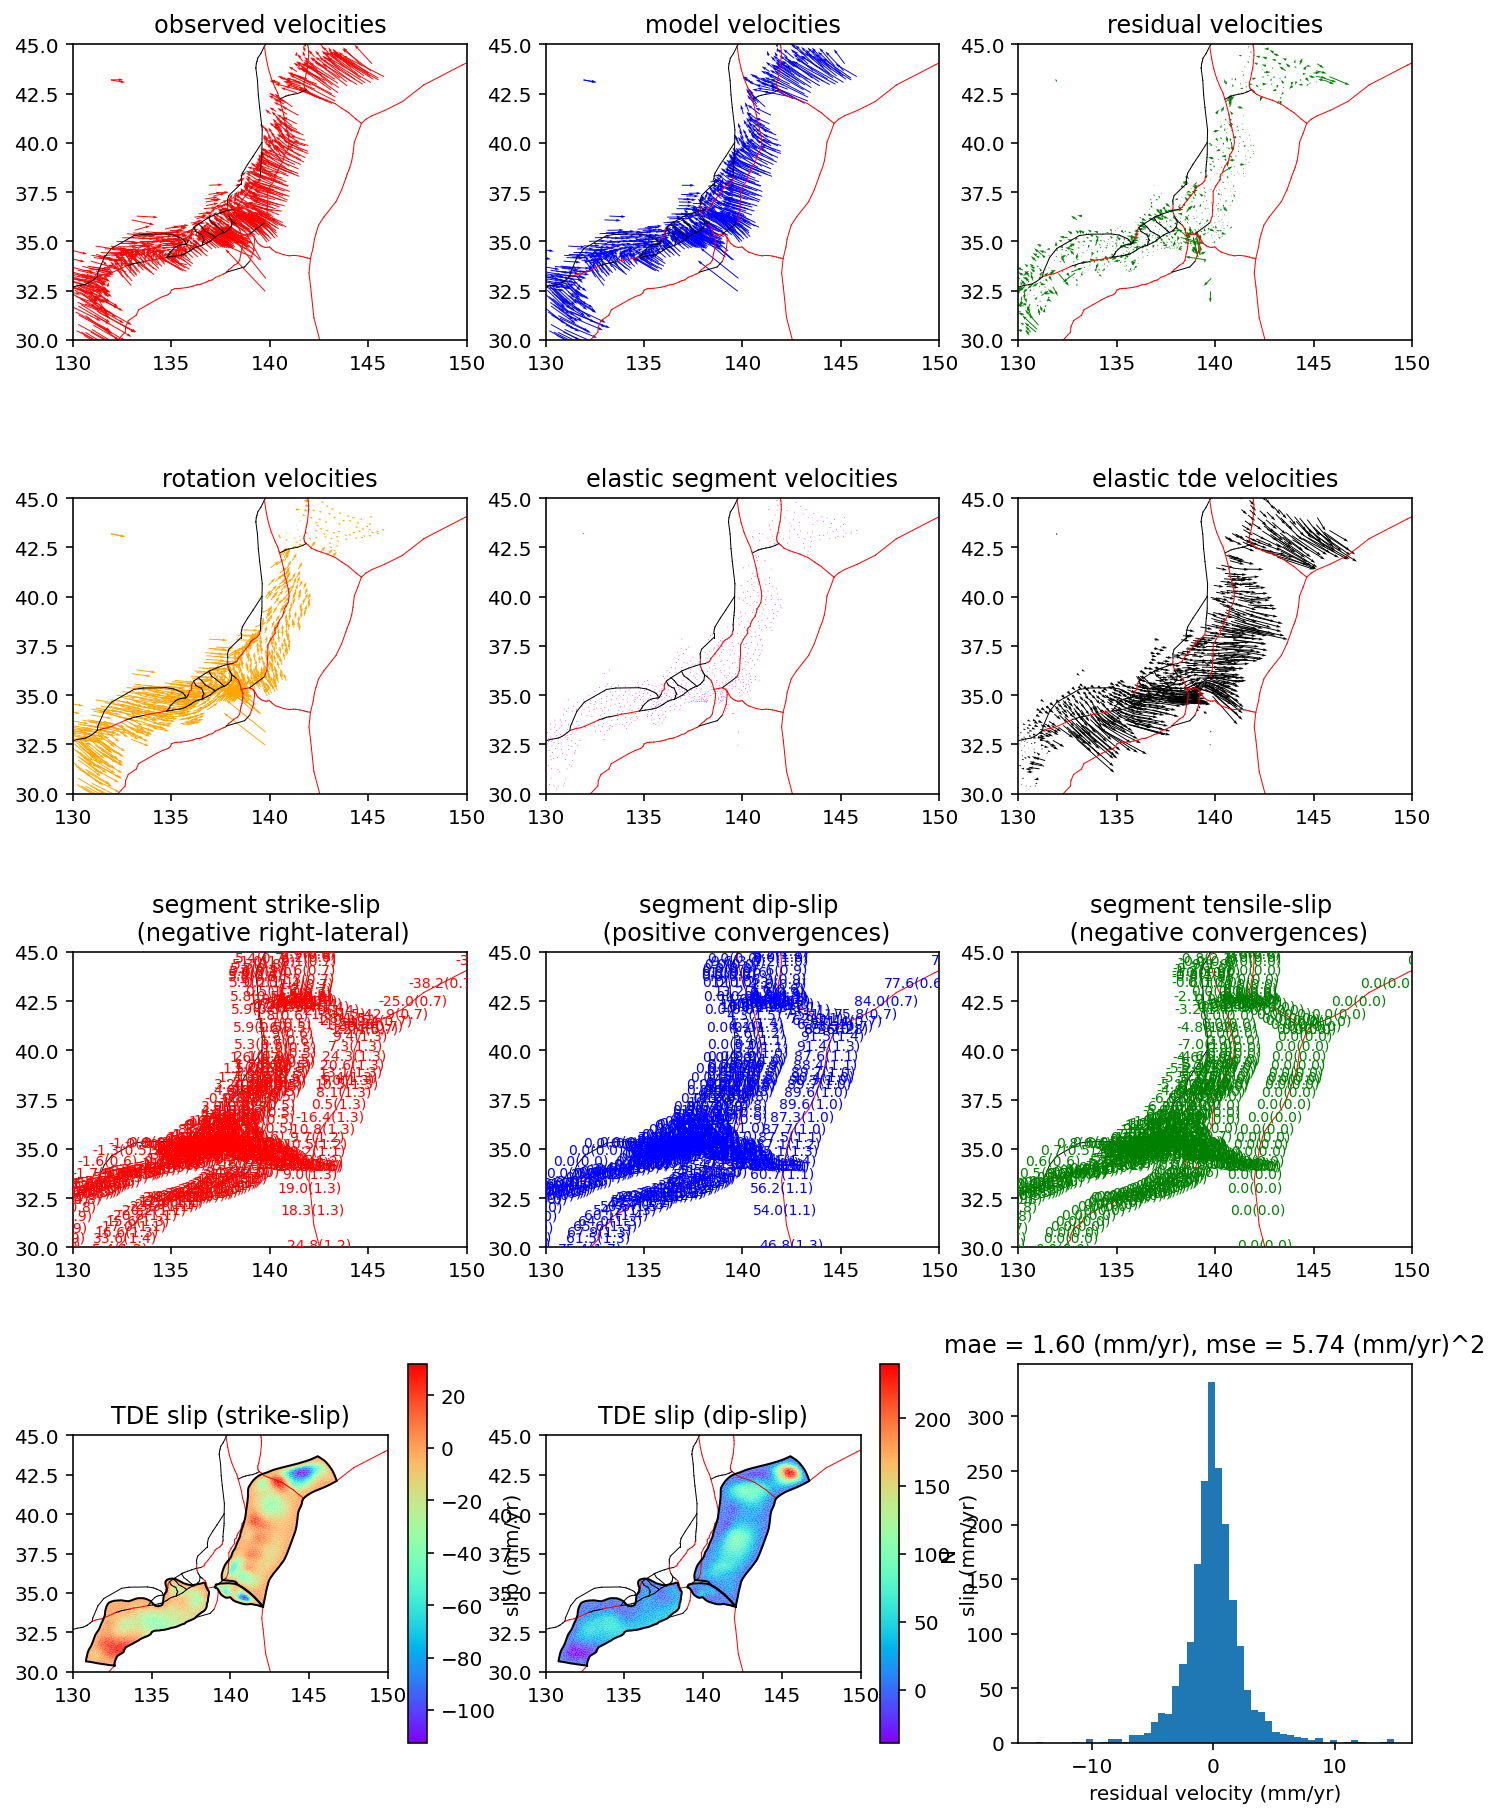

2023-03-02 21:34:35.465 | SUCCESS  | celeri.celeri:plot_estimation_summary:4544 - Wrote figures../runs/2023-03-02-21-33-21/plot_estimation_summary.(pdf, png)


<Figure size 432x288 with 0 Axes>

In [28]:
celeri.plot_estimation_summary(
    command,
    segment,
    station,
    meshes,
    estimation,
    lon_range=command.lon_range,
    lat_range=command.lat_range,
    quiver_scale=1e2,
)


In [29]:
# N_GRID_X = 500
# N_GRID_Y = 500
# def inpolygon(xq, yq, xv, yv):
#     shape = xq.shape
#     xq = xq.reshape(-1)
#     yq = yq.reshape(-1)
#     xv = xv.reshape(-1)
#     yv = yv.reshape(-1)
#     q = [(xq[i], yq[i]) for i in range(xq.shape[0])]
#     p = matplotlib.path.Path([(xv[i], yv[i]) for i in range(xv.shape[0])])
#     return p.contains_points(q).reshape(shape)


# # def rbf_interpolate(fill_value):
# #     # Observation coordinates and data
# #     x_vec = np.linspace(231, 239, N_GRID_X)
# #     y_vec = np.linspace(38, 52, N_GRID_Y)
# #     x_mat, y_mat = np.meshgrid(x_vec, y_vec)
# #     y_mat = y_mat
# #     centroids_lon = meshes[0].centroids[:, 0]
# #     centroids_lat = meshes[0].centroids[:, 1]
# #     centroids_val = fill_value

# #     # Package for RBFInterpolator
# #     xgrid = np.stack((x_mat, y_mat))
# #     xflat = xgrid.reshape(2, -1).T
# #     xobs = np.vstack((centroids_lon, centroids_lat)).T
# #     yobs = centroids_val
# #     yflat = scipy.interpolate.RBFInterpolator(
# #         xobs, yobs, kernel="cubic", smoothing=0.01, epsilon=1.5
# #     )(xflat)
# #     ygrid = yflat.reshape(N_GRID_X, N_GRID_Y)
# #     return xgrid, ygrid

# def rbf_interpolate2(fill_value):
#     # Observation coordinates and data
#     x_vec = np.linspace(231, 239, N_GRID_X)
#     y_vec = np.linspace(38, 52, N_GRID_Y)
#     x_mat, y_mat = np.meshgrid(x_vec, y_vec)
#     y_mat = y_mat
#     centroids_lon = meshes[0].centroids[:, 0]
#     centroids_lat = meshes[0].centroids[:, 1]
#     centroids_val = fill_value

#     # Package for RBFInterpolator
#     xgrid = np.stack((x_mat, y_mat))
#     xflat = xgrid.reshape(2, -1).T
#     xobs = np.vstack((centroids_lon, centroids_lat)).T
#     yobs = centroids_val
#     yflat = scipy.interpolate.RBFInterpolator(
#         xobs, yobs, kernel="cubic", smoothing=0.01, epsilon=1.5
#     )(xflat)

#     # yflat = scipy.interpolate.RBFInterpolator(
#     #     xobs, yobs, kernel="cubic", smoothing=0.00, epsilon=1.0
#     # )(xflat)
#     ygrid = yflat.reshape(N_GRID_X, N_GRID_Y)
#     return xgrid, ygrid

# fill_value = estimation.tde_dip_slip_rates
# xgrid, ygrid = rbf_interpolate2(fill_value)

# xflat = xgrid.reshape(2, -1).T
# inpolygon_vals = inpolygon(
#     xflat[:, 0], xflat[:, 1], meshes[0].x_perimeter, meshes[0].y_perimeter
# )
# inpolygon_vals = np.reshape(inpolygon_vals, (N_GRID_X, N_GRID_Y))
# ygrid[~inpolygon_vals] = np.nan



In [30]:
# # Smooth contour figure of Cascadia mesh
# # Plot
# plt.figure(figsize=(10, 10))
# N_CONTOUR_LEVELS = 10

# # Magnitude 9
# levels = np.array([1, 5, 10, 15, 20, 25])
# cmap = cc.cm.CET_L19
# # # Magnitude 9

# # # Magnitude 8
# # levels = np.array([1, 2, 4, 6, 8, 10])
# # cmap=cc.cm.CET_L19
# # # Magnitude 8

# # # Magnitude 7
# # levels = np.array([0.1, 1, 2, 3, 4, 5])
# # cmap=cc.cm.CET_L19
# # # Magnitude 7

# # # Magnitude 6
# # levels = np.array([0.1, 0.5, 1.0])
# # cmap=cc.cm.CET_L19
# # # Magnitude 6

# # cmap=cc.cm.isolum
# # cmap_base = cc.cm.CET_R1
# # cmap_base = cc.cm.CET_L8_r
# # vmin, vmax = 0.0, 0.75
# # cmap_base = "magma_r"
# # vmin, vmax = 0.0, 0.65
# # cmap = truncate_colormap(cmap_base, vmin, vmax)

# plt.contourf(*xgrid, ygrid, cmap=cmap, levels=levels, extend="both")
# cb = plt.colorbar(cax=plt.gca().inset_axes((0.05, 0.05, 0.03, 0.35)), label="slip (m)")
# cb.set_label(label="slip deficit rate (mm/yr)", size=18)
# cb.ax.tick_params(labelsize=18)
# plt.contour(
#     *xgrid, ygrid, colors="k", linestyles="solid", linewidths=0.5, levels=levels
# )
# plt.gca().set_aspect("equal", adjustable="box")
# plt.plot(meshes[0].x_perimeter, meshes[0].y_perimeter, "-k", linewidth=1.0)
# # plt.title(f"$M$ = {event.magnitude:0.3}", fontsize=18)
# plt.xlim([231, 239])
# plt.ylim([39, 52])
# plt.xticks([231, 235, 239])
# plt.yticks([40, 46, 52])
# plt.gca().set_facecolor("gainsboro")
# plt.tick_params(labelsize=18)
# plt.savefig("cascadia_slip_deficit_rate_contourf.pdf")
# plt.savefig("cascadia_slip_deficit_rate_contourf.png", dpi=500)
# plt.show()


In [31]:
cascadia_low_resolution_tde_dip_slip_rates = estimation.tde_dip_slip_rates
np.save(
    "cascadia_low_resolution_tde_dip_slip_rates.npy",
    cascadia_low_resolution_tde_dip_slip_rates,
)


In [32]:
cascadia_low_resolution_tde_dip_slip_rates = np.load("cascadia_low_resolution_tde_dip_slip_rates.npy")


In [33]:
cascadia_low_resolution_tde_dip_slip_rates

array([2.09428910e+01, 1.72615368e+01, 1.33192072e+01, ...,
       2.31058034e+00, 2.58657244e+00, 4.00689456e-09])

In [34]:
estimation.tde_dip_slip_rates.shape


(4754,)

In [35]:
import rich
rich.print(index.start_tde_col)


{0: 63, 1: 3867, 2: 9109}

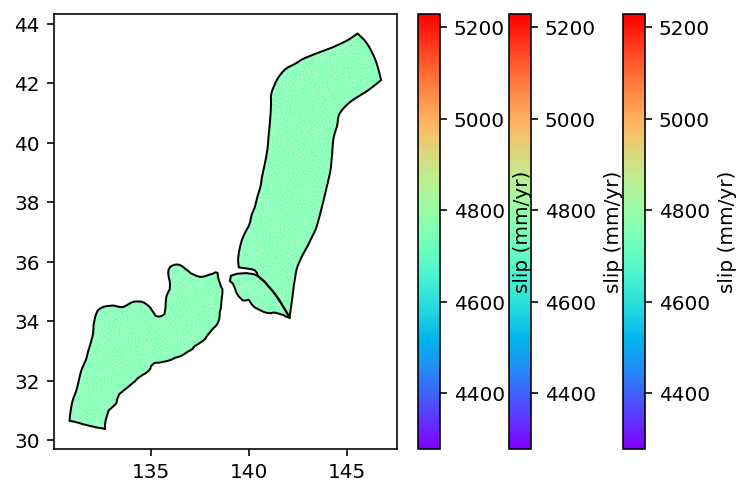

In [36]:
celeri.plot_meshes(meshes, estimation.tde_dip_slip_rates.shape, plt.gca())

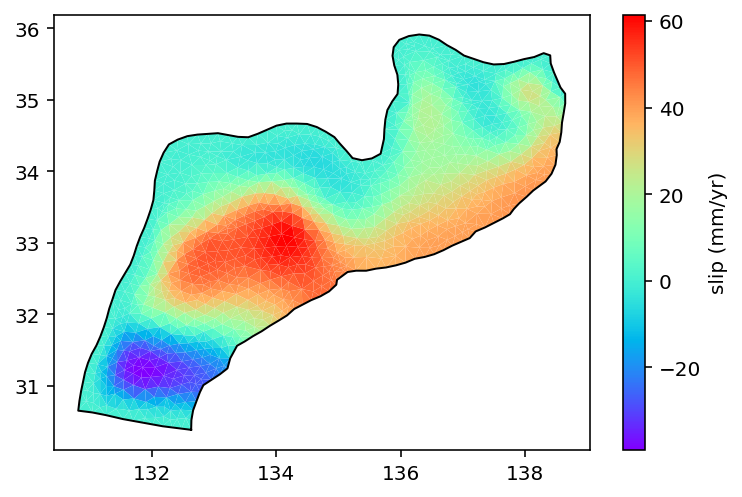

In [39]:
def plot_mesh(mesh, fill_value, ax):
    x_coords = mesh.meshio_object.points[:, 0]
    y_coords = mesh.meshio_object.points[:, 1]
    vertex_array = np.asarray(mesh.verts)

    if not ax:
        ax = plt.gca()
    xy = np.c_[x_coords, y_coords]
    verts = xy[vertex_array]
    pc = matplotlib.collections.PolyCollection(
        verts, edgecolor="none", cmap="rainbow"
    )
    pc.set_array(fill_value)
    ax.add_collection(pc)
    ax.autoscale()
    plt.colorbar(pc, label="slip (mm/yr)")

    # Add mesh edge
    x_edge = x_coords[mesh.ordered_edge_nodes[:, 0]]
    y_edge = y_coords[mesh.ordered_edge_nodes[:, 0]]
    x_edge = np.append(x_edge, x_coords[mesh.ordered_edge_nodes[0, 0]])
    y_edge = np.append(y_edge, y_coords[mesh.ordered_edge_nodes[0, 0]])
    plt.plot(x_edge, y_edge, color="black", linewidth=1)

fill_value = np.random.rand(meshes[0].n_tde)
fill_value = estimation.tde_dip_slip_rates[0:meshes[0].n_tde]
plot_mesh(meshes[0], fill_value, plt.gca())


nankai_low_resolution_tde_dip_slip_rates = estimation.tde_dip_slip_rates[0:meshes[0].n_tde]
np.save(
    "nankai_low_resolution_tde_dip_slip_rates.npy",
    nankai_low_resolution_tde_dip_slip_rates,
)


In [38]:
meshes[0].n_tde

1902

In [41]:
!pwd

/Users/meade/Desktop/celeri/notebooks
